In [1]:
## first block of code is just importing the requirements of the project

import sys 
import os
import h5py
import pickle
from matplotlib import pyplot as plt

from scipy import ndimage as ndi
from scipy import stats as sstats

import math
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from random import shuffle
from tqdm import tqdm, tnrange, tqdm_notebook
import collections
import random
import mahotas 
from sklearn.preprocessing import normalize
from PIL import Image
import imutils
import logging

from glob import glob

In [2]:
# this block of code is importing all the various parts of the project from their respective modules
from icon_util import *
from methods import *
from aberrations import *

In [3]:
image_set_name = "icon10"

# simple way to load the complete dataset (for a more sophisticated generator example, see LLD-logo script)
# open hdf5 file
hdf5_file = h5py.File('LLD-icon.hdf5', 'r')
# load data into memory as numpy array
#images, labels = (hdf5_file['data'][:], hdf5_file['labels/resnet/rc_64'][:])

# alternatively, h5py objects can be used like numpy arrays without loading the whole dataset into memory:
images, _ = (hdf5_file['data'], hdf5_file['labels/resnet/rc_64'])
# here, images[0] will be again returned as a numpy array and can eg. be viewed with matplotlib using
images = [np.transpose(i) if i.shape[0] == 3 else i for i in images[:10]]
print(len(images))

method_classes = [zernike_method, orb_method, neural_method, sift_method, contour_method]
#method_classes = [orb_method]

10


In [4]:
# uncomment this if you want to generate the databases
#generate_databases(images, method_classes, image_set_name)
methods = load_databases(method_classes, image_set_name)
print("Loading Completed")
#####################
# main loop 	#####
#####################
#results, scores = run(methods, images)
run_in_chunks(methods, images, aberrations[:1], chunk_size=100, weights=[0.10353353, 0.17799655, 0.05596501, 0.35731078, 0.30519413])
print("Done")

Loading Completed
Chunk: 1
Done


In [5]:
# Load all the logs into a single dataframe for processing
log_files = glob("Logs/*") # these are the logs that we're loading
print(log_files)
joined_logs = pd.concat([pd.read_csv(i) for i in log_files])
print(joined_logs)

['Logs\\results_1.csv', 'Logs\\results_2.csv', 'Logs\\results_3.csv']
   aberration             method  score  rank      time
0       ab_id     zernike_method -566.7     1  0.029781
1       ab_id         orb_method  100.0     1  0.420283
2       ab_id      neural_method  100.0     1  0.147290
3       ab_id        sift_method  100.0     1  0.064784
4       ab_id     contour_method  100.0     1  0.122328
..        ...                ...    ...   ...       ...
65      ab_id      neural_method  100.0     1  0.126140
66      ab_id        sift_method  100.0     1  0.036471
67      ab_id     contour_method  100.0     1  0.088220
68      ab_id    combined_method -566.7    10  0.000031
69      ab_id  uwcombined_method -566.7    10  0.000020

[210 rows x 5 columns]


Ranking


Text(0.5, 1.0, 'Combined')

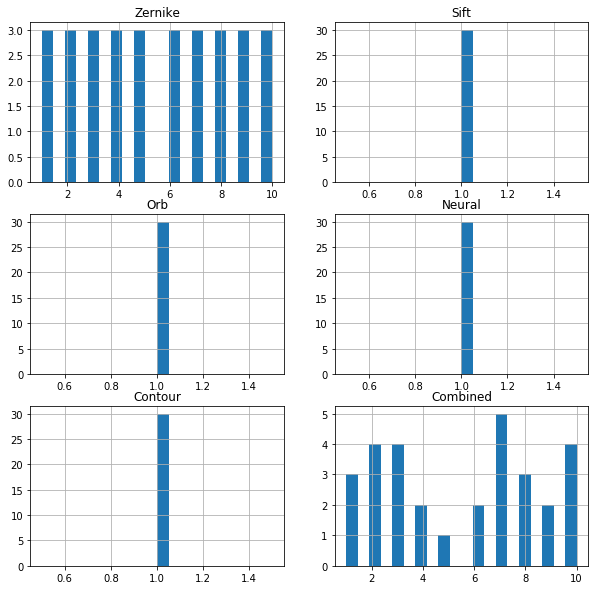

In [6]:
print("Ranking")
fig, axes = plt.subplots(nrows=3, ncols=2)
joined_logs[joined_logs['method']=='zernike_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[0,0])
axes[0,0].set_title('Zernike')
joined_logs[joined_logs['method']=='sift_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[0,1])
axes[0,1].set_title('Sift')
joined_logs[joined_logs['method']=='orb_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[1,0])
axes[1,0].set_title('Orb')
joined_logs[joined_logs['method']=='neural_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[1,1])
axes[1,1].set_title('Neural')
joined_logs[joined_logs['method']=='contour_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[2,0])
axes[2,0].set_title('Contour')
joined_logs[joined_logs['method']=='combined_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[2,1])
axes[2,1].set_title('Combined')

Timing


[(0, 0.2)]

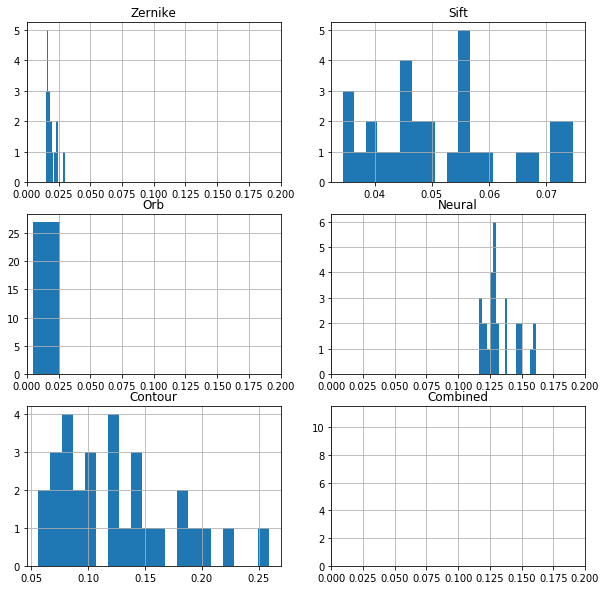

In [7]:
print("Timing")
fig, axes = plt.subplots(nrows=3, ncols=2)
joined_logs[joined_logs['method']=='zernike_method']['time'].hist(bins=20, figsize=(10,10), ax=axes[0,0])
axes[0,0].set_title('Zernike')
axes[0,0].set(xlim=(0,0.2))
joined_logs[joined_logs['method']=='sift_method']['time'].hist(bins=20, figsize=(10,10), ax=axes[0,1])
axes[0,1].set_title('Sift')
#axes[0,1].set(xlim=(0,0.2))
joined_logs[joined_logs['method']=='orb_method']['time'].hist(bins=20, figsize=(10,10), ax=axes[1,0])
axes[1,0].set_title('Orb')
axes[1,0].set(xlim=(0,0.2))
joined_logs[joined_logs['method']=='neural_method']['time'].hist(bins=20, figsize=(10,10), ax=axes[1,1])
axes[1,1].set_title('Neural')
axes[1,1].set(xlim=(0,0.2))
joined_logs[joined_logs['method']=='contour_method']['time'].hist(bins=20, figsize=(10,10), ax=axes[2,0])
axes[2,0].set_title('Contour')
#axes[2,0].set(xlim=(0,0.2))
joined_logs[joined_logs['method']=='combined_method']['time'].hist(bins=20, figsize=(10,10), ax=axes[2,1])
axes[2,1].set_title('Combined')
axes[2,1].set(xlim=(0,0.2))

Text(0.5, 1.0, 'Unweighted Combined')

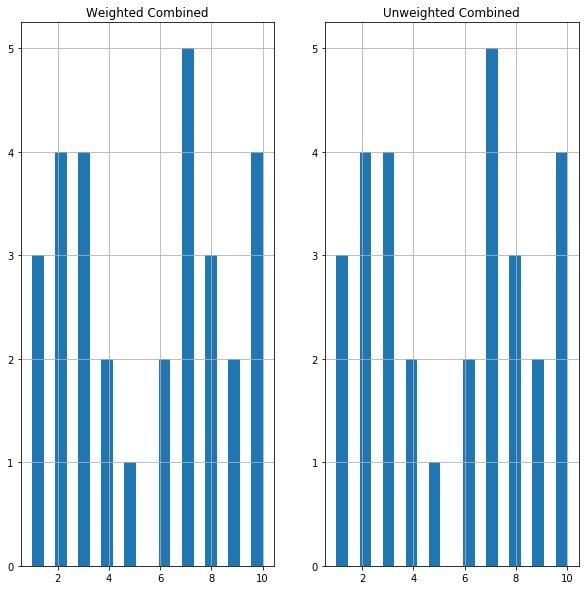

In [8]:
# joined_logs[joined_logs['method']=='neural_method']['rank'].plot.hist(bins=100)
# joined_logs.plot.kde()
# pd.plotting.andrews_curves(joined_logs['rank'], 'method')
# print(list('ABCD'))

#joined_logs.groupby('method').plot.hist()
#joined_logs[['method', 'rank']].hist(by='method')
#joined_logs[['method','rank','aberration']].groupby('method').plot.hist(bins=100, label='method')
#joined_logs.groupby('method').plot(kind='hist', subplots=True, figsize=(6,6))
#joined_logs[joined_logs['method']=='zernike_method'].hist(bins=20, figsize=(20,20))
#joined_logs[(joined_logs['method']=='zernike_method') & (joined_logs['aberration']=='ab_id')]
fig, axes = plt.subplots(nrows=1, ncols=2)
joined_logs[joined_logs['method']=='combined_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[0])
axes[0].set_title('Weighted Combined')
joined_logs[joined_logs['method']=='uwcombined_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[1])
axes[1].set_title('Unweighted Combined')

In [9]:
# ## plot query image and top 11 hits, just for checking purposes  
# plot_results(Data, matched_list_v2)

In [26]:
# Logistic regression

# Load all the Training data into a single dataframe for processing
log_files = glob("Training/*") # these are the logs that we're loading
print(log_files)
training_logs = pd.concat([pd.read_csv(i) for i in log_files])
print(training_logs)

numbers = [i for i in range(len(images))]
random.shuffle(numbers)
training = numbers[0:int(0.8*len(images))]
test = numbers[len(training):]
print(str(len(training))+" training images")
print(str(len(test))+" test images")

training_set = training_logs[training_logs["idx"].astype(int).isin(training)]
training_data = training_set[training_set.columns[:5]].to_numpy()
training_labels = training_set[training_set.columns[5]].to_numpy()

clf = LogisticRegression(random_state = 0, solver = 'lbfgs', multi_class = 'multinomial').fit(training_data, training_labels)
logistic_weights = clf.coef_[0]/sum(clf.coef_[0])
print('Logistic Weights')
print(logistic_weights)

['Training\\results_1.csv']
    zernike_method  orb_method  neural_method  sift_method  contour_method  \
0           -566.7         100      99.999994          100           100.0   
1           -566.7          18      78.829914            0            17.1   
2           -566.7          40      78.518021            0            13.7   
3           -566.7          40      84.642372            2            10.8   
4           -566.7          27      77.657568            2            13.3   
..             ...         ...            ...          ...             ...   
95          -566.7          58      82.636783           13             6.7   
96          -566.7          31      82.004482           10             7.1   
97          -566.7          36      84.590650            0             7.4   
98          -566.7          39      81.811634           13             7.1   
99          -566.7         100     100.000000          100           100.0   

    labels  idx  
0        1    9  

In [11]:
###### logsitic regression for weights of 4 methods
numbers = [i for i in range(100,200)]

### randomly create training and test set
random.shuffle(numbers)
training = numbers[0:60]
testing = numbers[60:100]

### search for a particular mutation
mutation_string = 'ab_line_circle'
print(mutation_string)

### set threshold for contour and sift, set accuracy cutoff (top 10 or top 20)
contour_thresh = 0
sift_thresh = 0
rank_cutoff = 20

### create training set, filter for mutation name and thresholds 
input_score_mutation = input_score[(input_score["mutation"].str.find(mutation_string) > -1) & (input_score["image"].astype(float).isin(training)) & ((input_score["contour_orig"].astype(float) >= contour_thresh) & (input_score["sift_orig"].astype(float) >= sift_thresh))]
input_score_mutation = input_score_mutation.values

### create test data set, not used for training
input_score_test = input_score[(input_score["mutation"].str.find(mutation_string) > -1) & (input_score["image"].astype(float).isin(testing) ) & ((input_score["contour_orig"].astype(float) >= contour_thresh) & (input_score["sift_orig"].astype(float) >= sift_thresh))]
input_score_test = pd.DataFrame(input_score_test,columns = ['contour_score','zernike_score','sift_score','orb_score','image','success','mutation','contour_orig','sift_orig'])

### run logistic regression on training data
clf = LogisticRegression(random_state = 0, solver = 'lbfgs', multi_class = 'multinomial').fit(input_score_mutation[:,(0,1,2,3)], input_score_mutation[:,5])
logistic_weights = clf.coef_[0]/sum(clf.coef_[0])
print('Logistic Weights')
print(logistic_weights)

### use weights to calculate weighted score and rank on training set
input_score_mutation = pd.DataFrame(input_score_mutation,columns = ['contour_score','zernike_score','sift_score','orb_score','image','success','mutation','contour_orig','sift_orig'])

input_score_mutation["contour_score"] = input_score_mutation["contour_score"].astype(float)
input_score_mutation["zernike_score"] = input_score_mutation["zernike_score"].astype(float)
input_score_mutation["sift_score"] = input_score_mutation["sift_score"].astype(float)
input_score_mutation["orb_score"] = input_score_mutation["orb_score"].astype(float)

input_score_mutation["avg_score"] = .25*input_score_mutation["contour_score"] + .25*input_score_mutation["zernike_score"] + .25*input_score_mutation["sift_score"] + .25*input_score_mutation["orb_score"]
input_score_mutation["weight_score"] = logistic_weights[0]*input_score_mutation["contour_score"] + logistic_weights[1]*input_score_mutation["zernike_score"] + logistic_weights[2]*input_score_mutation["sift_score"] + logistic_weights[3]*input_score_mutation["orb_score"]
input_score_mutation['Avg_Rank'] = input_score_mutation.groupby(['image','mutation'])['avg_score'].rank(ascending=False)	
input_score_mutation['Weight_Rank'] = input_score_mutation.groupby(['image','mutation'])['weight_score'].rank(ascending=False)	

### use weights to calculate weighted score and rank on test set
input_score_test["contour_score"] = input_score_test["contour_score"].astype(float)
input_score_test["zernike_score"] = input_score_test["zernike_score"].astype(float)
input_score_test["sift_score"] = input_score_test["sift_score"].astype(float)
input_score_test["orb_score"] = input_score_test["orb_score"].astype(float)

input_score_test["avg_score"] = .25*input_score_test["contour_score"] + .25*input_score_test["zernike_score"] + .25*input_score_test["sift_score"] + .25*input_score_test["orb_score"]
input_score_test["weight_score"] = logistic_weights[0]*input_score_test["contour_score"] + logistic_weights[1]*input_score_test["zernike_score"] + logistic_weights[2]*input_score_test["sift_score"] + logistic_weights[3]*input_score_test["orb_score"]
input_score_test['Avg_Rank'] = input_score_test.groupby(['image','mutation'])['avg_score'].rank(ascending=False)	
input_score_test['Weight_Rank'] = input_score_test.groupby(['image','mutation'])['weight_score'].rank(ascending=False)	

### check the rank of the original image, see if image was within the top 10 or top 20 search results
successes = input_score_mutation[input_score_mutation["success"].astype(float) == 1]

avg_rank = sum(successes['Avg_Rank'])/successes.shape[0]
weight_rank = sum(successes['Weight_Rank'])/successes.shape[0]
top10_avg_rank = len( successes[(successes['Avg_Rank'] <= rank_cutoff)] )
top10_weight_rank = len( successes[(successes['Weight_Rank'] <= rank_cutoff)] )

print('Training Accuracy')
print((top10_avg_rank,top10_weight_rank))

successes_t = input_score_test[input_score_test["success"].astype(float) == 1]

avg_rank_t = sum(successes_t['Avg_Rank'])/successes_t.shape[0]
weight_rank_t = sum(successes_t['Weight_Rank'])/successes_t.shape[0]
top10_avg_rank_t = len( successes_t[(successes_t['Avg_Rank'] <= rank_cutoff)] )
top10_weight_rank_t = len( successes_t[(successes_t['Weight_Rank'] <= rank_cutoff)] )

print('Testing Accuracy')
print((top10_avg_rank_t,top10_weight_rank_t))

#input_score.to_csv(path_or_buf='./score_result_2.csv', sep=',',index = False)

ab_line_circle


NameError: name 'input_score' is not defined

In [ ]:
# ### display an image
# image_index = 50
# Data = gray(images[image_index])
# Data, mutation = ab_random(Data, n = 9)

# imgplot = plt.imshow(Data, cmap=plt.cm.gray)
# plt.axis('off')
# plt.show()